In [4]:
import pandas as pd
import os
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def load_and_prepare_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
    df.sort_values("datetime", inplace=True)
    return df

def calculate_arbitrage_spread_pct(df):
    df["second"] = df["datetime"].dt.floor("s")

    grouped = df.groupby("second", group_keys=False)
    arbitrage_df = grouped.apply(lambda g: pd.Series({
        "spread_pct": (g["bid1_price"].max() - g["ask1_price"].min()) / g["ask1_price"].min() * 100,
        "best_buy_ex": g.loc[g["ask1_price"].idxmin(), "exchange"],
        "best_sell_ex": g.loc[g["bid1_price"].idxmax(), "exchange"]
    })).reset_index()

    return arbitrage_df

def plot_orderbook_with_arbitrage_pct(df, save_dir):
    df["second"] = df["datetime"].dt.floor("s")
    arbitrage_df = calculate_arbitrage_spread_pct(df)

    exchanges = df['exchange'].unique()
    symbol = df["symbol"][0]
    color_pool = px.colors.qualitative.Plotly
    color_map = {exch: color_pool[i % len(color_pool)] for i, exch in enumerate(exchanges)}

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=(f"{symbol} Bid1 / Ask1 Price Trends", "Arbitrage Spread (%)"))

    # 📈 Row 1：各交易所 Bid / Ask 折线图
    for exchange in exchanges:
        sub_df = df[df['exchange'] == exchange]
        color = color_map[exchange]

        fig.add_trace(go.Scatter(
            x=sub_df["datetime"],
            y=sub_df["bid1_price"],
            mode="lines",
            name=f"{exchange} Bid",
            line=dict(color=color, width=1, dash="dash"),
            opacity=0.7,
            hovertemplate=f"{exchange} Bid<br>%{{x}}<br>%{{y}}<extra></extra>"
        ), row=1, col=1)

        fig.add_trace(go.Scatter(
            x=sub_df["datetime"],
            y=sub_df["ask1_price"],
            mode="lines",
            name=f"{exchange} Ask",
            line=dict(color=color, width=1, dash="solid"),
            opacity=0.7,
            hovertemplate=f"{exchange} Ask<br>%{{x}}<br>%{{y}}<extra></extra>"
        ), row=1, col=1)

    # 🔶 Row 2：套利差价百分比 + 最佳交易所展示
    fig.add_trace(go.Scatter(
        x=arbitrage_df["second"],
        y=arbitrage_df["spread_pct"],
        mode="lines+markers",
        name="Arbitrage (%)",
        line=dict(color="orange", width=2),
        opacity=0.9,
        hovertemplate=(
            "Time: %{x}<br>"
            "Spread: %{y:.4f}%<br>"
            "Best Buy Exchange: %{customdata[0]}<br>"
            "Best Sell Exchange: %{customdata[1]}<extra></extra>"
        ),
        customdata=arbitrage_df[["best_buy_ex", "best_sell_ex"]].values
    ), row=2, col=1)

    fig.update_layout(
        title=f"{symbol} Across Exchanges – Price & Arbitrage %",
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis2_title="Time",
        yaxis2_title="Spread (%)",
        hovermode="x unified",
        template="plotly_white",
        legend_title="Type",
        height=700
    )
    symbol = symbol.replace("/", "_").replace(":", "_")
    fig.show()
    # os.makedirs(save_dir, exist_ok=True)
    # html_path = os.path.join(save_dir, f"{symbol}.html")

    # fig.write_html(html_path, auto_open=True)  # 👈 自动打开图表
    # print(f"✅ 可交互图已保存并显示：{html_path}")

# 🌀 扫描 CSV 文件夹并处理
# csv_dir = "../csv_orderbooks_symbol"
# for fname in os.listdir(csv_dir):
#     if fname.endswith(".csv"):
#         symbol = os.path.splitext(fname)[0]
#         try:
#             df = load_and_prepare_csv(os.path.join(csv_dir, fname))
#             plot_orderbook_with_arbitrage_pct(df, symbol)
#         except Exception as e:
#             print(f"⚠️ Error processing {fname}: {e}")
#         break  # 如需批量处理可删除 break


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2100\3407688828.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



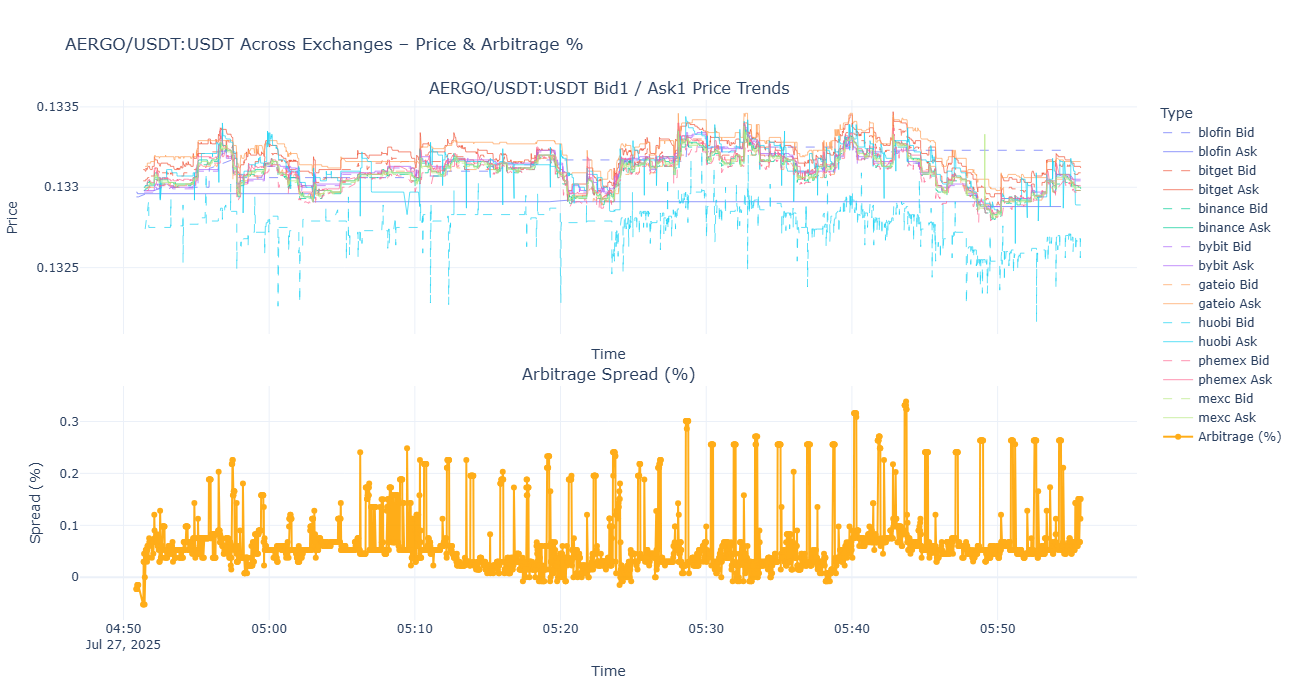

In [8]:
df = load_and_prepare_csv(os.path.join("../csv_orderbooks_symbol/", 'ob_AERGO_USDT_USDT.csv'))
plot_orderbook_with_arbitrage_pct(df, "out_html")

In [24]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, HoverTool, CheckboxGroup, Button, CustomJS
from bokeh.palettes import Category10

def plot_orderbook_with_bokeh(df):
    arbitrage_df = calculate_arbitrage_spread_pct(df)
    exchanges = df["exchange"].unique()
    symbol = df["symbol"].iloc[0]

    width = 1400  # ⬅️ 放大图表宽度
    price_fig = figure(title=f"{symbol} Bid / Ask Price Trends", x_axis_type="datetime", height=350, width=width)
    arbitrage_fig = figure(title="Arbitrage Spread (%)", x_axis_type="datetime", height=250, width=width)

    lines = []
    labels = []

    for i, exchange in enumerate(exchanges):
        sub = df[df["exchange"] == exchange]
        source_bid = ColumnDataSource(data=dict(x=sub["datetime"], y=sub["bid1_price"]))
        source_ask = ColumnDataSource(data=dict(x=sub["datetime"], y=sub["ask1_price"]))

        line_bid = price_fig.line("x", "y", source=source_bid, line_color=Category10[10][i % 10],
                                  line_dash="dashed", line_width=2, legend_label=f"{exchange} Bid")
        line_ask = price_fig.line("x", "y", source=source_ask, line_color=Category10[10][i % 10],
                                  line_dash="solid", line_width=2, legend_label=f"{exchange} Ask")

        lines.extend([line_bid, line_ask])
        labels.extend([f"{exchange} Bid", f"{exchange} Ask"])

    price_fig.legend.click_policy = "hide"
    price_fig.add_tools(HoverTool(tooltips=[("Time", "@x{%F %T}"), ("Price", "@y")],
                                  formatters={"@x": "datetime"}, mode="vline"))

    arb_source = ColumnDataSource(data=dict(
        x=arbitrage_df["second"],
        y=arbitrage_df["spread_pct"],
        buy=arbitrage_df["best_buy_ex"],
        sell=arbitrage_df["best_sell_ex"]
    ))

    arbitrage_fig.circle("x", "y", source=arb_source, size=5, color="orange", alpha=0.8)
    arbitrage_fig.line("x", "y", source=arb_source, line_color="orange", line_width=2)
    arbitrage_fig.add_tools(HoverTool(tooltips=[
        ("Time", "@x{%F %T}"),
        ("Spread %", "@y{0.0000}"),
        ("Best Buy", "@buy"),
        ("Best Sell", "@sell")
    ], formatters={"@x": "datetime"}, mode="vline"))

    # 🔘 控制器一排铺平
    checkbox = CheckboxGroup(labels=labels, active=list(range(len(lines)),), width=width - 200)
    select_btn = Button(label="✅ 全选", width=80)
    clear_btn = Button(label="❌ 清空", width=80)

    checkbox.js_on_change("active", CustomJS(args=dict(lines=lines), code="""
        for (let i = 0; i < lines.length; i++) {
            lines[i].visible = cb_obj.active.includes(i);
        }
    """))

    select_btn.js_on_click(CustomJS(args=dict(checkbox=checkbox), code="""
        checkbox.active = [...Array(checkbox.labels.length).keys()];
        checkbox.change.emit();
    """))

    clear_btn.js_on_click(CustomJS(args=dict(checkbox=checkbox), code="""
        checkbox.active = [];
        checkbox.change.emit();
    """))

    # 📐 控件和图表组合
    layout = column(row(select_btn, clear_btn, checkbox), price_fig, arbitrage_fig)
    show(layout)


In [25]:
df = load_and_prepare_csv(os.path.join("../csv_orderbooks_symbol/", 'ob_AERGO_USDT_USDT.csv'))
plot_orderbook_with_bokeh(df)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2100\1567752911.py:17: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

